# 평가문항 - 상세기준
- 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.
    - 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.
- 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.
    - 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
- WEAT score 계산 및 시각화를 정상적으로 진행하였다.
    - 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.

In [171]:
# 파일 저장 커스텀 모듈

import sys
sys.path.append("../custom")

from importlib import reload
import custom_utils
reload(custom_utils)

from custom_utils import save_var, load_var


In [1]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.6.0
4.3.1
1.3.0
0.12.2


STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [5]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open('./data/synopsis/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

KeyboardInterrupt: 

In [ ]:
save_var(tokenized, "synopsis_tokenized")

In [6]:
tokenized = load_var("synopsis_tokenized")

# STEP 2. 추출된 결과로 embedding model 만들기

In [242]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

In [243]:
model.save("word2vec_tokenized")
tmp = model
model = Word2Vec.load("word2vec_tokenized")

In [244]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.8924322724342346),
 ('다큐멘터리', 0.8464943766593933),
 ('드라마', 0.8251158595085144),
 ('영화로', 0.8076703548431396),
 ('가족영화', 0.7800189256668091),
 ('형식', 0.7788148522377014),
 ('주제', 0.7743354439735413),
 ('코미디', 0.7727371454238892),
 ('스토리', 0.7647455334663391),
 ('소재', 0.7586115002632141)]

# STEP 3. target, attribute 단어 셋 만들기

In [10]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

In [2]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [9]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open('./data/synopsis/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

## 토큰화: 예술 영화 / 일반 영화

In [ ]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

art = read_token(art_txt)
gen = read_token(gen_txt)

In [81]:
art = load_var("art_token")
gen = load_var("gen_token")

In [83]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [84]:
feature_names = vectorizer.get_feature_names_out()
print(len(feature_names))
print(feature_names[:5])

41082
['가가' '가가린' '가가호호' '가감' '가게']


In [85]:
vocab_index = vectorizer.vocabulary_['히트']
print(vocab_index)
print(vectorizer.get_feature_names_out()[vocab_index])

41039
히트


In [86]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

In [129]:
print(len(w1), len(w2))

18995 37717


In [88]:
print(f'예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print('\n')
    
print(f'일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [144]:
w1_, w2_ = [], []
for i in range(200):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

In [145]:
print(len(w1_), len(w2_))

200 200


In [146]:
print(w1_[:5])
print(w2_[:5])

['귀요미', '인상파', '스트라스부르', '우승', '비인간']
['인상파', '귀요미', '여드름', '우승', '비유']


In [150]:
n = 15
n_range = 200

# w1에만 있고 w2에는 없는, 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(n_range):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if i >= n_range-1: print(i)
        
# w2에만 있고 w1에는 없는, 대표하는 단어를 15개 추출한다.
for i in range(n_range):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    # if len(target_gen) > n: break
    if i >= n_range-1: print(i)

199
199


In [151]:
len(target_art), len(target_gen)

(21, 25)

In [152]:
print(target_art)
print(target_gen)

['마스', '해구', '마돈나', '성지', '공부', '성격', '남산', '단지', '스쿠버다이빙', '엑스맨', '마르고', '콜로서스', '모티브', '제니퍼', '고수로', '진욱', '대장장이', '알론', '유례', '독립선언', '피카']
['아테나', '에세이', '보장', '유람선', '보직', '귀순', '도발', '경악', '복역', '사심', '학예회', '인간성', '트래셔', '종점', '골칫거리', '조련사', '디아즈', '박태호', '공정', '대북', '이등병', '사카', '노도', '가게', '대가리']


> 이 단어들이 정말 대표 단어라고 할 수 있는건가???

## 토큰화: 장르별 텍스트

In [14]:
for genre in genre_txt:
    print(genre.split(".")[0])

synopsis_SF
synopsis_family
synopsis_show
synopsis_horror
synopsis_etc
synopsis_documentary
synopsis_drama
synopsis_romance
synopsis_musical
synopsis_mystery
synopsis_crime
synopsis_historical
synopsis_western
synopsis_adult
synopsis_thriller
synopsis_animation
synopsis_action
synopsis_adventure
synopsis_war
synopsis_comedy
synopsis_fantasy


In [15]:
genre_tokenized = {}
for genre in genre_txt:
    genre_name = genre.split(".")[0]
    genre_tokenized[genre_name] = read_token(genre)
    save_var(genre_tokenized[genre_name], f"{genre_name}_tokenized")

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [16]:
f_name = "genre_tokenized"
save_var(genre_tokenized, f_name)
temp = genre_tokenized
genre_tokenized = load_var(f_name)

In [17]:
genre_tokenized.keys()

dict_keys(['synopsis_SF', 'synopsis_family', 'synopsis_show', 'synopsis_horror', 'synopsis_etc', 'synopsis_documentary', 'synopsis_drama', 'synopsis_romance', 'synopsis_musical', 'synopsis_mystery', 'synopsis_crime', 'synopsis_historical', 'synopsis_western', 'synopsis_adult', 'synopsis_thriller', 'synopsis_animation', 'synopsis_action', 'synopsis_adventure', 'synopsis_war', 'synopsis_comedy', 'synopsis_fantasy'])

In [21]:
genre_names = [genre.split(".")[0].split("_")[1] for genre in genre_txt]
genre_names

['SF',
 'family',
 'show',
 'horror',
 'etc',
 'documentary',
 'drama',
 'romance',
 'musical',
 'mystery',
 'crime',
 'historical',
 'western',
 'adult',
 'thriller',
 'animation',
 'action',
 'adventure',
 'war',
 'comedy',
 'fantasy']

In [24]:
genre_names = [genre.split(".")[0] for genre in genre_txt]
genre_names

['synopsis_SF',
 'synopsis_family',
 'synopsis_show',
 'synopsis_horror',
 'synopsis_etc',
 'synopsis_documentary',
 'synopsis_drama',
 'synopsis_romance',
 'synopsis_musical',
 'synopsis_mystery',
 'synopsis_crime',
 'synopsis_historical',
 'synopsis_western',
 'synopsis_adult',
 'synopsis_thriller',
 'synopsis_animation',
 'synopsis_action',
 'synopsis_adventure',
 'synopsis_war',
 'synopsis_comedy',
 'synopsis_fantasy']

In [223]:
genre = []
for genre_name in genre_names:
    genre.append(genre_tokenized[genre_name])
len(genre)

21

### 대표 단어 추출

In [186]:
def extract_sorted_features(X):
    """Returns features sorted by TF-IDF score."""
    coo_matrices = [X[i].tocoo() for i in range(X.shape[0])]
    sorted_features = [
        sorted(zip(mm.col, mm.data), key=lambda x: x[1], reverse=True) 
        for mm in coo_matrices
    ]
    return sorted_features

In [398]:
def extract_attributes(sorted_features, vectorizer, model, max_attributes=100, selection=False):
    """Extracts representative attributes for each genre."""
    attributes = []
    selected_attributes = set()  # 선택된 단어들 세트
    
    feature_names = vectorizer.get_feature_names_out()
    for feature_list in sorted_features:
        attr = []
        for col_idx, _ in feature_list:
            word = feature_names[col_idx]
            # 다른 장르에서 선택된 단어들이 아닌 단어를 선택
            if word in model.wv and word not in selected_attributes:
                attr.append(word)
                selected_attributes.add(word)  # 선택된 단어를 세트에 추가
            if len(attr) >= max_attributes:
                break
        attributes.append(attr)
    
    return attributes

In [408]:
# vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(max_df=0.85)
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 41675)


In [409]:
# Extract features sorted by TF-IDF score
sorted_features = extract_sorted_features(X)

# Extract representative attributes for each genre
attributes = extract_attributes(sorted_features, vectorizer, model, max_attributes=20, selection=False)

> 좋은 방법은 아닌 것 같지만, 앞서 다른 장르에서 선택된 단어가 아닌 단어를 선택한다.

In [410]:
f_name = "attributes_default_max085"
# f_name = "attributes_set_100"
save_var(attributes, f_name)
tmp = attributes
attributes = load_var(f_name)

In [394]:
for genre_name, attr in zip(genre_names, attributes):
    print(f"{genre_name}: {', '.join(attr)}")

synopsis_SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성
synopsis_family: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이
synopsis_show: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 카르피, 비바, 왕자, 콘서트, 백작부인
synopsis_horror: 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 영화, 사실, 소녀, 하나, 살인
synopsis_etc: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 여자, 대한, 독립, 친구, 작품
synopsis_documentary: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 통해, 그녀, 여성, 가족, 한국
synopsis_drama: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 가족, 단편, 서울, 대한, 아들
synopsis_romance: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 관계, 부부, 엄마, 아버지, 사실
synopsis_musical: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 프롤, 모도, 카르피, 시작, 제루샤
synopsis_mystery: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 아이, 민혁, 사실, 의문, 미스

> TFIDF: default  
> 그녀, 자신, 시작, 여자, 남자, 친구, 이야기 등등 중복된 단어들이 많이 보인다. 

In [401]:
for genre_name, attr in zip(genre_names, attributes):
    print(f"{genre_name}: {', '.join(attr)}")

synopsis_SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성
synopsis_family: 엄마, 아빠, 가족, 영화제, 친구, 아주르, 아버지, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 학교, 소년, 슈이트, 이야기
synopsis_show: 오페라, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키
synopsis_horror: 사건, 공포, 죽음, 악령, 남자, 좀비, 영화, 사실, 소녀, 하나, 살인, 비밀, 정체, 저주, 살해, 여자, 의문, 점점, 사고, 명의
synopsis_etc: 서울, 단편, 뉴미디어, 페스티벌, 대한, 독립, 작품, 통해, 아시아나, 다른, 우리, 연출, 모습, 시간, 이미지, 부산, 기억, 상영작, 지하철, 청소년
synopsis_documentary: 다큐, 다큐멘터리, 감독, 여성, 한국, 환경, 사회, 노동자, 가장, 기록, 역사, 음악, 미국, 카메라, 동안, 대해, 과정, 도시, 지역, 투쟁
synopsis_drama: 마음, 남편, 서로, 다시, 관계, 생각, 아내, 사이, 때문, 부문, 어머니, 생활, 결혼, 인생, 간다, 순간, 여행, 현실, 일상, 의도
synopsis_romance: 섹스, 부부, 회사, 유혹, 연애, 애인, 새엄마, 불륜, 남자친구, 유부녀, 감정, 정사, 출장, 선배, 과연, 여자친구, 커플, 한편, 만난, 고백
synopsis_musical: 뮤지컬, 에스메랄다, 충무로, 모차르트, 니웨, 바흐, 페뷔스, 프롤, 모도, 제루샤, 샤오캉, 데이비, 팬텀, 최고, 크리스틴, 애니, 노트르담, 라훌, 캬바레, 안젤로
synopsis_mystery: 진실, 민혁, 미스터리, 형사, 경찰, 현우, 발생, 방독면, 범인, 모두, 충격, 소설, 용의자, 여인,

> TFIDF: word selection  
> 중복된 단어들이 제거되었다. 

In [411]:
for genre_name, attr in zip(genre_names, attributes):
    print(f"{genre_name}: {', '.join(attr)}")

synopsis_SF: 지구, 인류, 우주, 로봇, 박사, 우주선, 외계, 행성, 실험, 시스템, 위협, 생명체, 스타크, 리플리, 과학자, 파괴, 켈빈, 컨트, 수퍼맨, 요원
synopsis_family: 아주르, 낙타, 씨제이, 동구, 슈이트, 마갈, 미아, 펠리칸, 벤트, 케이시, 할아버지, 엠마, 고양이, 크리스마스, 최호, 요정, 혜지, 유나, 테리, 번개
synopsis_show: 오페라, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키
synopsis_horror: 악령, 좀비, 저주, 의문, 시체, 악몽, 유령, 게임, 귀신, 악마, 바이러스, 부부, 현상, 사라, 괴물, 살인마, 판타스틱, 부천, 인형, 그날
synopsis_etc: 단편, 뉴미디어, 페스티벌, 독립, 아시아나, 연출, 이미지, 상영작, 지하철, 청소년, 노인, 포럼, 메트로, 단편영화, 풍경, 부문, 실험영화, 애니메이션, 대화, 배우
synopsis_documentary: 다큐, 다큐멘터리, 환경, 노동자, 투쟁, 인디다큐페스티발, 북한, 문화, 건축, 인터뷰, 자연, 질문, 관객, 당시, 여정, 등반, 밴드, 노래, 인권영화제, 건축사
synopsis_drama: 상처, 회사, 애인, 섹스, 남자친구, 전주, 동네, 오늘, 선생님, 마치, 관심, 여자친구, 로서, 드라마, 퀴어, 표현, 고백, 초청, 고등학교, 이혼
synopsis_romance: 연애, 새엄마, 불륜, 유부녀, 정사, 출장, 선배, 동거, 시아버지, 욕구, 마사지, 성욕, 은밀, 직장, 언니, 형부, 자위, 형수, 현우, 위로
synopsis_musical: 뮤지컬, 에스메랄다, 충무로, 모차르트, 니웨, 바흐, 페뷔스, 프롤, 모도, 제루샤, 샤오캉, 데이비, 팬텀, 크리스틴, 애니, 노트르담, 라훌, 캬바레, 안젤로, 파두
synopsis_mystery: 민혁, 미스터리, 형사, 방독면, 용

> TFIDF: default, max 0.85  
> 중복된 단어들이 잘 보이지 않는다.  
> 그러나... 고유명사들(스타크, 리플리, 아주르, 케이시, 혜지, 유나 등)이 많이 선택되어 적절한 대표단어가 추출된 것 같지는 않다.  

# STEP 4. WEAT score 계산과 시각화

In [59]:
import numpy as np
from numpy import dot
from numpy.linalg import norm


In [57]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [136]:
def weat_score(X, Y, A, B):

    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    score = (mean_X-mean_Y)/std_dev
    
    # print(score)
    
    return score

In [358]:
matrix = [[0 for _ in range(len(genre_names))] for _ in range(len(genre_names))]

In [362]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

In [363]:
len(X), len(Y)

(21, 25)

In [367]:
X_20 = X[:20]
Y_20 = Y[:20]

In [368]:
len(X_20), len(Y_20)

(20, 20)

In [391]:
attributes = load_var("attributes_default")
# attributes = load_var("attributes_set")

In [412]:
for i in range(len(genre_names)-1):
    for j in range(i+1, len(genre_names)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X_20, Y_20, A, B)

In [413]:
f_name = "genre_matrix_default_max085"
# f_name = "genre_matrix_set"
save_var(matrix, f_name)
tmp = matrix
matrix = load_var(f_name)

In [155]:
for i in range(len(genre_names)-1):
    for j in range(i+1, len(genre_names)):
        print(genre_names[i], genre_names[j],matrix[i][j])

synopsis_SF synopsis_family 0.5834592
synopsis_SF synopsis_show -0.15665422
synopsis_SF synopsis_horror 0.40947413
synopsis_SF synopsis_etc 0.14008117
synopsis_SF synopsis_documentary 0.42085403
synopsis_SF synopsis_drama 0.53845584
synopsis_SF synopsis_romance 0.29112524
synopsis_SF synopsis_musical -0.008326557
synopsis_SF synopsis_mystery 0.10888969
synopsis_SF synopsis_crime 0.115221195
synopsis_SF synopsis_historical -0.17761096
synopsis_SF synopsis_western 0.10568356
synopsis_SF synopsis_adult 0.021710984
synopsis_SF synopsis_thriller 0.35821897
synopsis_SF synopsis_animation -0.22512354
synopsis_SF synopsis_action -0.48289287
synopsis_SF synopsis_adventure 0.016954813
synopsis_SF synopsis_war -0.07929506
synopsis_SF synopsis_comedy 0.17988038
synopsis_SF synopsis_fantasy 0.0378017
synopsis_family synopsis_show -0.5555974
synopsis_family synopsis_horror -0.58751726
synopsis_family synopsis_etc -0.50199014
synopsis_family synopsis_documentary -0.33368546
synopsis_family synopsis_d

In [185]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(matrix, genre_names, title='Art/General Movie Heatmap', font_scale=0.7, figsize=(8, 6)):
    np.random.seed(0)

    sns.set_style("whitegrid")
    sns.set_context("talk", font_scale=font_scale)
    sns.set(font='courier')

    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=figsize)

    ax = sns.heatmap(
        matrix, 
        xticklabels=genre_names, 
        yticklabels=genre_names, 
        annot=True,  
        cmap='RdYlGn_r',
        annot_kws={"size": 6}
    )

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('X-axis', fontsize=12)
    ax.set_ylabel('Y-axis', fontsize=12)

    return ax

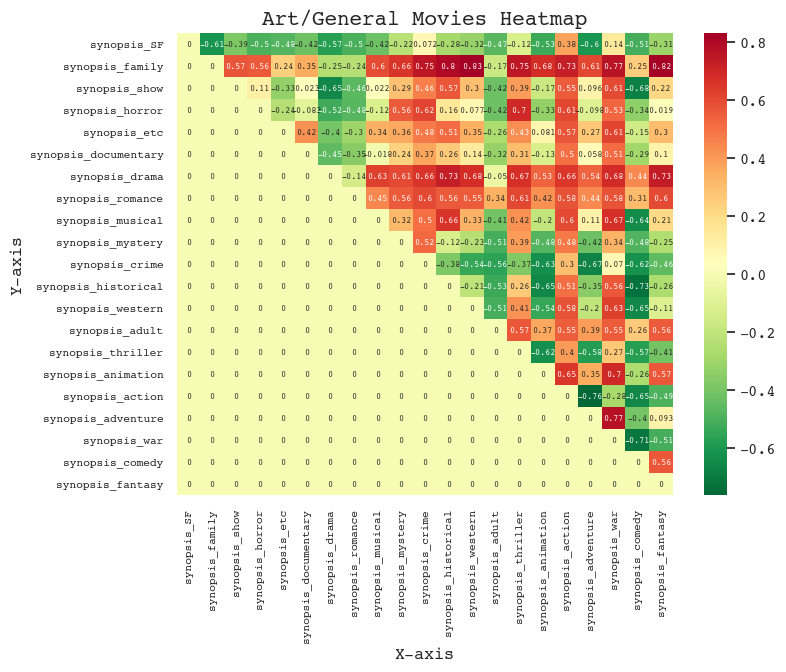

In [414]:
ax = plot_heatmap(matrix, genre_names, "Art/General Movies Heatmap")
fig = ax.get_figure()

In [415]:
save_var(fig, "plot_default_max085")

### TF-IDF 기본 설정

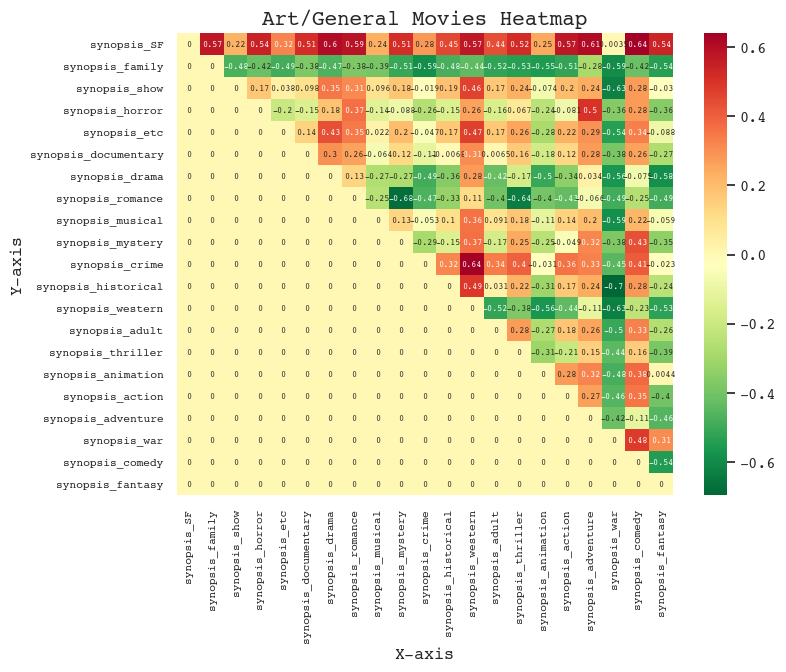

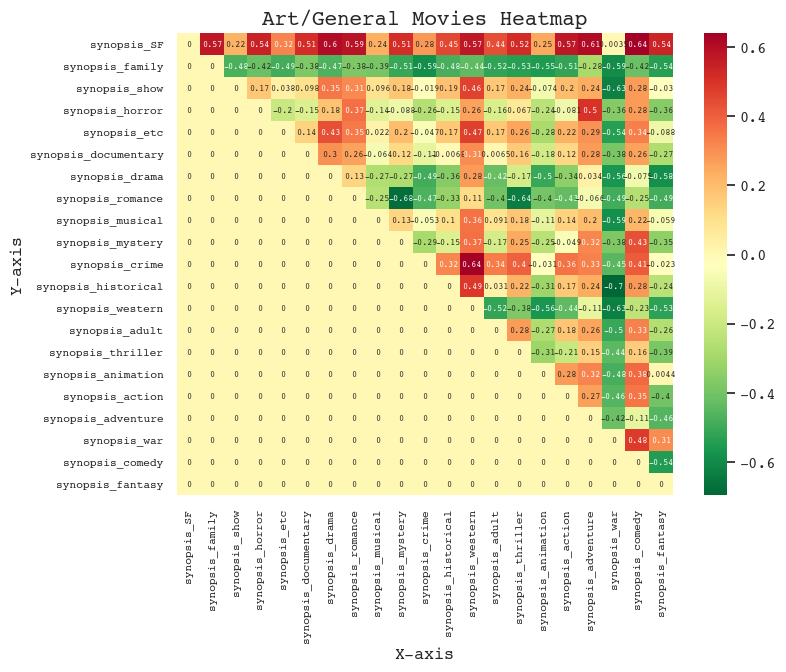

In [417]:
fig = load_var("plot_default_20230821_181539")
fig

> SF 장르는 거의 다른 장르와의 WEAT score 값이 높게 나온다.

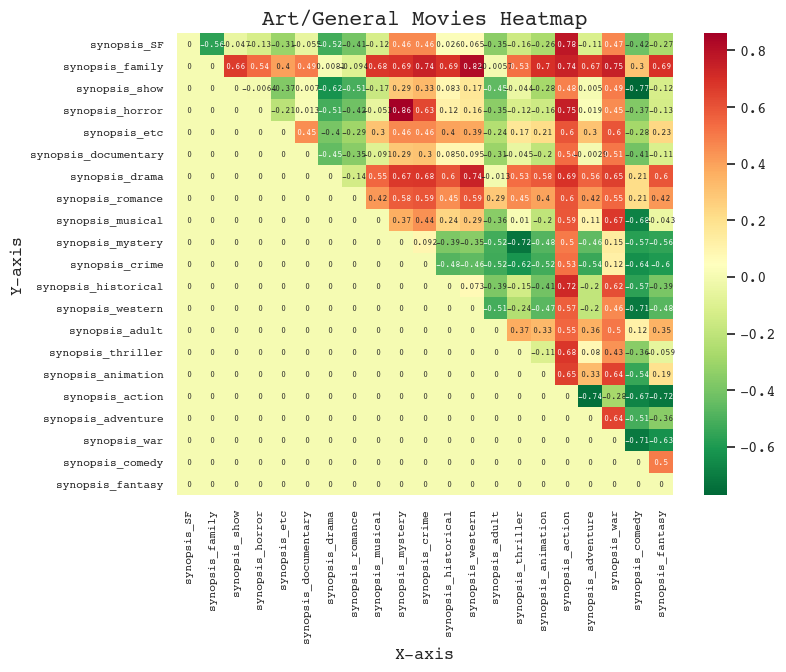

In [407]:
fig = load_var("plot_selection")
fig

> 중복되지 않는 단어를 선택한 결과,  
> SF 장르에서 거의 모든 장르와의 WEAT score 값이 높았던 부분이 많이 완화되었다.

### TF-IDF: max 0.85

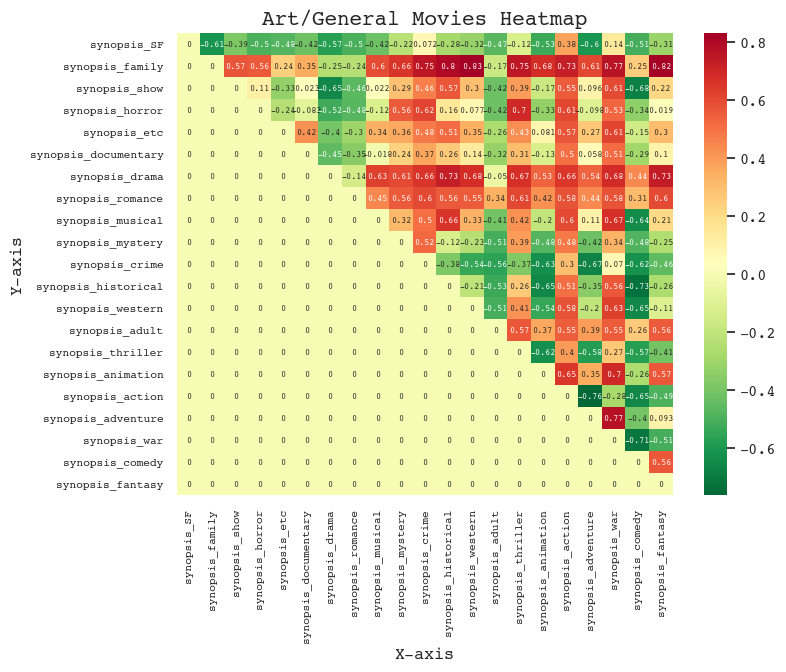

In [416]:
fig = load_var("plot_default_max085")
fig

> 중복단어를 선택하지 않고, TF-IDF max값을 0.85로 조정한 결과,   
> SF에서 WEAT 점수가 높게 나왔던 부분이 많이 줄어들었다.  
> 그러나... family, drama, romance 등의 장르에서 거의 모든 WEAT 점수가 높게 나온다.

# LDA

TF-IDF 의 한계를 느끼고,  
LDA 를 사용하여 분석해보고자 한다.

In [245]:
len(genre)

21

In [418]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), stop_words=None)
X = vectorizer.fit_transform(genre)

/Users/salgu/.pyenv/versions/aiffel/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [419]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 21

lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)


LatentDirichletAllocation(n_components=21, random_state=42)

In [420]:
def print_top_words(model, feature_names, n_words=10):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_words - 1:-1]])
        print(message)

In [421]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_words=20)

Topic #0: 그, 조선, 왕, 위해, 것, 수, 시작, 사랑, 의, 자신, 이, 그녀, 과, 은, 향, 최고, 운명, 사람, 날, 황제
Topic #1: 힝클리, 밸브, 뱃길, 뱃고동, 뱃, 뱀파이어, 뱀탕집, 뱀장어, 뱀버, 뱀, 밸린저, 버거운, 밸리, 밸런타인데이, 밸런스, 밸, 밴프, 밴쿠버, 밴스, 밴디트
Topic #2: 그, 위해, 것, 이, 자신, 사건, 시작, 수, 알, 의, 경찰, 조직, 은, 중, 날, 사람, 그녀, 살인, 를, 돈
Topic #3: 힝클리, 밸브, 뱃길, 뱃고동, 뱃, 뱀파이어, 뱀탕집, 뱀장어, 뱀버, 뱀, 밸린저, 버거운, 밸리, 밸런타인데이, 밸런스, 밸, 밴프, 밴쿠버, 밴스, 밴디트
Topic #4: 힝클리, 밸브, 뱃길, 뱃고동, 뱃, 뱀파이어, 뱀탕집, 뱀장어, 뱀버, 뱀, 밸린저, 버거운, 밸리, 밸런타인데이, 밸런스, 밸, 밴프, 밴쿠버, 밴스, 밴디트
Topic #5: 힝클리, 밸브, 뱃길, 뱃고동, 뱃, 뱀파이어, 뱀탕집, 뱀장어, 뱀버, 뱀, 밸린저, 버거운, 밸리, 밸런타인데이, 밸런스, 밸, 밴프, 밴쿠버, 밴스, 밴디트
Topic #6: 힝클리, 밸브, 뱃길, 뱃고동, 뱃, 뱀파이어, 뱀탕집, 뱀장어, 뱀버, 뱀, 밸린저, 버거운, 밸리, 밸런타인데이, 밸런스, 밸, 밴프, 밴쿠버, 밴스, 밴디트
Topic #7: 그, 그녀, 것, 자신, 사랑, 날, 수, 이, 시작, 집, 위해, 남자, 사람, 친구, 영화제, 영화, 남편, 여자, 두, 일
Topic #8: 힝클리, 밸브, 뱃길, 뱃고동, 뱃, 뱀파이어, 뱀탕집, 뱀장어, 뱀버, 뱀, 밸린저, 버거운, 밸리, 밸런타인데이, 밸런스, 밸, 밴프, 밴쿠버, 밴스, 밴디트
Topic #9: 힝클리, 밸브, 뱃길, 뱃고동, 뱃, 뱀파이어, 뱀탕집, 뱀장어, 뱀버, 뱀, 밸린저, 버거운, 밸리, 밸런타인데이, 밸런스, 밸, 밴프, 밴쿠버, 밴스, 밴디트
Topic #10: 힝클리, 밸브, 뱃길, 뱃고동, 뱃, 뱀파이어, 뱀탕집, 뱀장어, 뱀버, 뱀,

> 왜 이렇게..... 나오지?

## 2nd

In [301]:
words_list = [words.split() for words in genre]

In [303]:
words_list[0][:10]

['시간', '지명', '알', '수', '한국', '가상', '도시', '산성비', '오염', '이']

In [304]:
id2word = gensim.corpora.Dictionary(words_list)

In [ ]:
id2word.filter_extremes(no_below = 2) #2회 이하로 등장한 단어는 삭제

In [308]:
for item in id2word.items():
    print(item)
    break

(0, '가게')


In [309]:
corpus=[id2word.doc2bow(words.split()) for words in genre]

In [316]:
from gensim.models.ldamodel import LdaModel
lda = LdaModel(corpus, num_topics=21)

In [317]:
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)

(13, '0.017*"493" + 0.011*"175" + 0.009*"497" + 0.007*"3349" + 0.006*"2005"')
(0, '0.024*"493" + 0.010*"175" + 0.009*"3246" + 0.008*"497" + 0.008*"3349"')
(7, '0.015*"493" + 0.010*"175" + 0.008*"2536" + 0.007*"497" + 0.007*"3246"')
(12, '0.013*"493" + 0.009*"175" + 0.008*"3522" + 0.006*"497" + 0.006*"2339"')
(4, '0.017*"493" + 0.010*"175" + 0.010*"3522" + 0.009*"3349" + 0.008*"3246"')
(11, '0.013*"493" + 0.011*"175" + 0.009*"3522" + 0.008*"3349" + 0.008*"2339"')
(15, '0.016*"493" + 0.011*"175" + 0.008*"3522" + 0.007*"3012" + 0.007*"497"')
(17, '0.022*"493" + 0.009*"175" + 0.007*"2339" + 0.007*"3349" + 0.007*"3760"')
(1, '0.017*"493" + 0.011*"175" + 0.009*"3349" + 0.008*"3760" + 0.008*"3012"')
(6, '0.017*"493" + 0.010*"175" + 0.008*"3522" + 0.007*"3012" + 0.007*"3349"')
(18, '0.020*"493" + 0.010*"3349" + 0.009*"3522" + 0.008*"175" + 0.008*"2536"')
(3, '0.016*"493" + 0.010*"175" + 0.007*"497" + 0.007*"2536" + 0.007*"2339"')
(10, '0.018*"493" + 0.010*"3522" + 0.008*"2339" + 0.008*"497" + 

In [314]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.1 MB/s eta 0:00:0031m32.7 MB/s eta 0:00:01


In [318]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, corpus, id2word)
pyLDAvis.display(vis)
